In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lichess_code 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [9]:
df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")
df=lichess_code.add_total_accuracy(df)
summary_table=lichess_code.create_summary_table(df)

In [15]:
# Assuming 'df' contains the columns 'GameID', 'Player', and 'Total_Accuracy'

# Remove duplicates to ensure one entry per player per game
df_unique = df[['GameID', 'Player', 'Total_Accuracy']].drop_duplicates()

# Pivot the DataFrame to have 'Total_Accuracy' for White and Black in separate columns
df_pivot = df_unique.pivot(index='GameID', columns='Player', values='Total_Accuracy').reset_index()

# Remove the 'Player' name from columns
df_pivot.columns.name = None

# Optionally rename the columns for clarity
df_pivot.rename(columns={'White': 'Total_Accuracy_White', 'Black': 'Total_Accuracy_Black'}, inplace=True)

# Compute the minimum Total_Accuracy per game
df_pivot['Min_Total_Accuracy'] = df_pivot[['Total_Accuracy_White', 'Total_Accuracy_Black']].min(axis=1)

# Sort the DataFrame by 'Min_Total_Accuracy' in ascending order
df_sorted = df_pivot.sort_values('Min_Total_Accuracy', ascending=True)

# Get the top N games with the lowest minimum Total_Accuracy scores
N = 10  # Adjust N as needed
lowest_N_games = df_sorted.head(N)

# Display the GameID and both players' Total_Accuracy
print(f"Games with the lowest {N} minimum Total_Accuracy scores:")
print(lowest_N_games[['GameID', 'Total_Accuracy_White', 'Total_Accuracy_Black']])


Games with the lowest 10 minimum Total_Accuracy scores:
        GameID  Total_Accuracy_White  Total_Accuracy_Black
33400  34648.0             15.961005             23.683236
14598  15051.0             17.481708             18.480995
33766  35021.0             20.136249             20.654277
33458  34707.0             43.318396             20.544295
26669  27708.0             21.030625             28.959492
14305  14755.0             23.551820             23.962847
21692  22493.0             29.992533             25.168910
8492    8785.0             25.608673             57.963982
33818  35073.0             26.433581             25.882547
24652  25555.0             30.018454             27.888580


In [11]:
low_elo = summary_table[ (summary_table['Elo'] <= 1500)]
low_elo.head()

,GameID,Year,Opening,Variation,Result,TotalMoves,Player,Name,Elo,FideId,Total_Accuracy
632,317.0,2021.0,Ruy Lopez,fianchetto defence deferred,0-1,64.0,White,"Polukhin,Sergey",1410.0,24252018.0,90.158296
635,318.0,2021.0,Other,Unknown,1-0,39.0,Black,"Iljin,Viktor",1066.0,34413472.0,76.550521
654,334.0,2021.0,Sicilian,Grand Prix attack,1/2-1/2,66.0,White,"Polukhin,Sergey",1410.0,24252018.0,89.908060
659,336.0,2021.0,King's pawn opening,Unknown,1-0,116.0,Black,"Iljin,Viktor",1066.0,34413472.0,88.716945
668,343.0,2021.0,French,exchange variation,1/2-1/2,94.0,White,"Polukhin,Sergey",1410.0,24252018.0,89.976157


In [12]:
lichess_code.export_game_to_pgn(df,317,'../game1.pgn')

In [10]:
top_100_openings = summary_table['Opening'].value_counts().nlargest(50).index.tolist()
summary_table['Opening'] = summary_table['Opening'].apply(lambda x: x if x in top_100_openings else 'Other')

new_summary_table = summary_table[summary_table['Player'] == 'White'].copy()
#new_summary_table = new_summary_table[ (new_summary_table['TotalMoves'] <= 60)]

In [20]:
categorical_features = ['Opening', 'Variation', 'Result']
numerical_features = ['Total_Accuracy', 'TotalMoves'] 
test_size=0.2 
random_state=42
   
# Prepare the feature matrix X and target vector y
features = categorical_features + numerical_features
X = summary_table[features]
y = summary_table['Elo']

# Handle missing values
X = X.fillna(0)
y = y.fillna(0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

# Create a ColumnTransformer to encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

# Create a pipeline that first transforms the data then applies Linear Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Optional: Get the coefficients of the model
# Get feature names after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combine with numerical feature names
feature_names = np.concatenate([onehot_feature_names, numerical_features])

# Get coefficients from the model
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Display the coefficients
print("\nCoefficients of the model:")
print(coef_df)




Root Mean Squared Error (RMSE): 489.61
R-squared Score (R²): 0.12

Coefficients of the model:
                         Feature  Coefficient
0     Opening_Alekhine's defence   -45.604834
1        Opening_Benko's opening    41.524870
2                 Opening_Benoni    38.598012
3         Opening_Benoni defence    58.435741
4         Opening_Bird's opening  -199.518176
...                          ...          ...
1028                  Result_1-0  -160.318115
1029               Result_1-0 ff   445.472156
1030              Result_1/2-1/2  -105.862244
1031              Total_Accuracy    14.078782
1032                  TotalMoves     0.523649

[1033 rows x 2 columns]


In [25]:
# Assume all necessary libraries are already imported and previous code has been executed
# The pipeline 'pipeline' has been trained, and 'categorical_features', 'numerical_features',
# and 'summary_table' are defined from your previous code.

# Step 1: Select 10 games with Elo > 2500
high_elo_games = summary_table[summary_table['Elo'] > 2500].copy()

# Check if there are at least 10 games; if not, adjust accordingly
if len(high_elo_games) < 10:
    print(f"Only {len(high_elo_games)} games found with Elo > 2500.")
    sample_games = high_elo_games
else:
    # Randomly select 10 games
    sample_games = high_elo_games.sample(n=10, random_state=42)

# Step 2: Preprocess the selected games


# Prepare the feature matrix
features = categorical_features + numerical_features
X_new = sample_games[features]

# Step 3: Predict using the trained model
y_new_pred = pipeline.predict(X_new)

# Step 4: Output the predictions per game
sample_games = sample_games.reset_index(drop=True)  # Reset index for clarity
sample_games['Predicted_Elo'] = y_new_pred

# Display the predictions per game
print("Predictions for each game:")
print(sample_games[['GameID', 'Elo', 'Predicted_Elo']])

# Step 5: Compute and display average, min, and max of the predictions
average_pred = y_new_pred.mean()
min_pred = y_new_pred.min()
max_pred = y_new_pred.max()

print(f"\nAverage Predicted Elo: {average_pred:.2f}")
print(f"Minimum Predicted Elo: {min_pred:.2f}")
print(f"Maximum Predicted Elo: {max_pred:.2f}")


Predictions for each game:
    GameID     Elo  Predicted_Elo
0  26704.0  2604.0    2283.281612
1  24300.0  2556.0    2168.077261
2  20449.0  2549.0    2289.323053
3  23921.0  2539.0    2216.740614
4  27437.0  2503.0    2383.158132
5  26775.0  2538.0    2091.556913
6  19727.0  2589.0    2429.281277
7  29501.0  2592.0    2364.590532
8  31682.0  2517.0    2297.367740
9  30991.0  2566.0    2340.140889

Average Predicted Elo: 2286.35
Minimum Predicted Elo: 2091.56
Maximum Predicted Elo: 2429.28


In [23]:
y_pred.max()

2659.009241629823

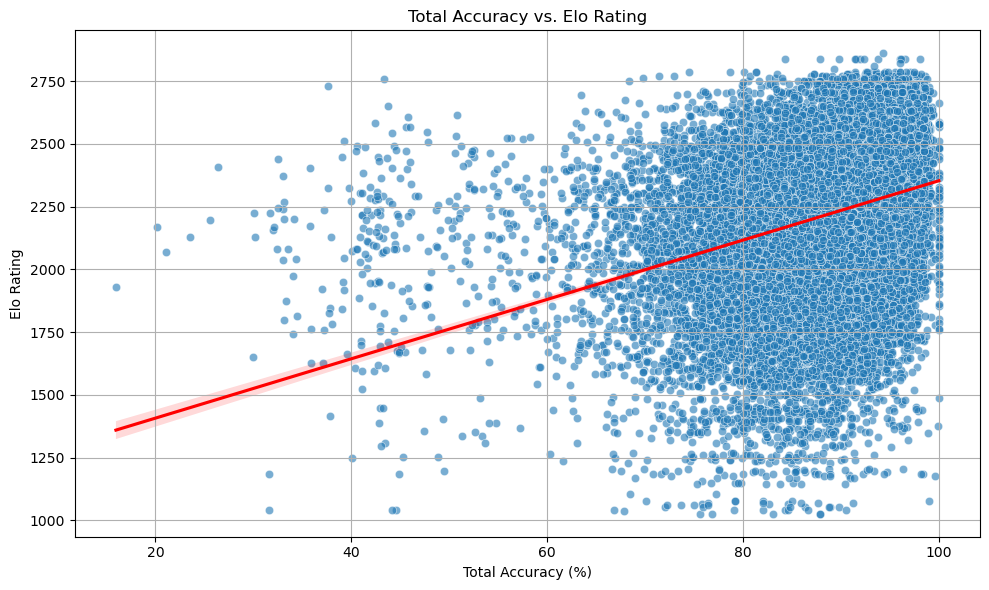

In [7]:
plot_data = new_summary_table.dropna(subset=['Total_Accuracy', 'Elo'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='Total_Accuracy', y='Elo', alpha=0.6)

# Add a regression line
sns.regplot(data=plot_data, x='Total_Accuracy', y='Elo', scatter=False, color='red')

# Customize the plot
plt.title('Total Accuracy vs. Elo Rating')
plt.xlabel('Total Accuracy (%)')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\foivo\AppData\Local\Temp\ipykernel_38848\771771032.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()


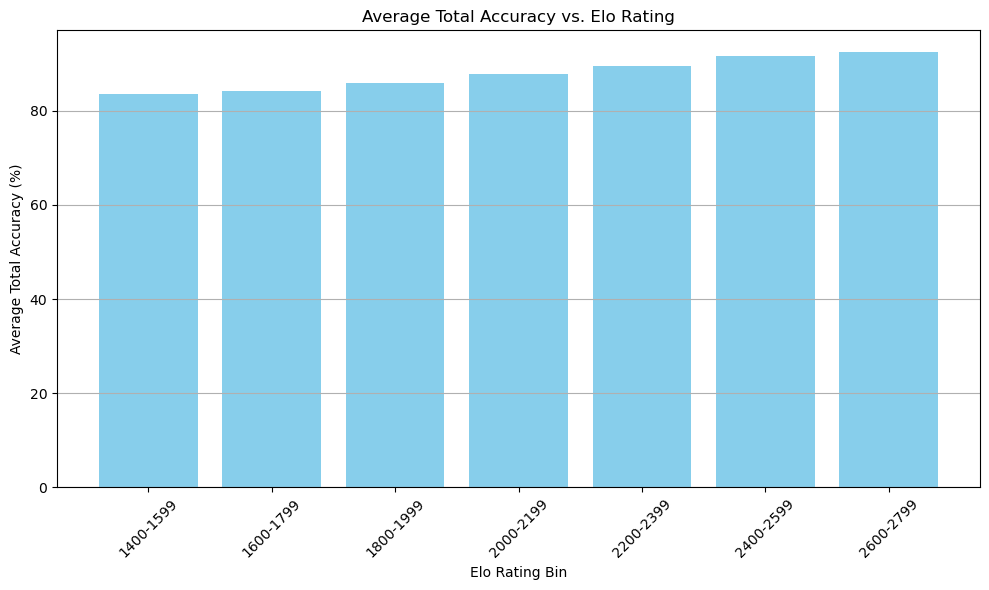

In [9]:

# Remove any rows with missing 'Elo' or 'Total_Accuracy'
data = new_summary_table.dropna(subset=['Elo', 'Total_Accuracy']).copy()

# Ensure 'Elo' is numeric
data['Elo'] = pd.to_numeric(data['Elo'], errors='coerce')

# Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]

elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1]
    upper = upper - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
data['EloBin'] = pd.cut(
    data['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Remove any rows where 'EloBin' is NaN (in case 'Elo' is outside the bins)
data = data.dropna(subset=['EloBin'])

# Compute average Total Accuracy per Elo bin
avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()

# Sort the bins in order
avg_accuracy_per_elo_bin['EloBin'] = pd.Categorical(avg_accuracy_per_elo_bin['EloBin'], categories=elo_labels, ordered=True)
avg_accuracy_per_elo_bin = avg_accuracy_per_elo_bin.sort_values('EloBin')

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(avg_accuracy_per_elo_bin['EloBin'], avg_accuracy_per_elo_bin['Total_Accuracy'], color='skyblue')
plt.title('Average Total Accuracy vs. Elo Rating')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Total Accuracy (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
def cp_to_win_percent(cp):
    """
    Convert centipawn evaluation to win percentage using the Lichess formula.

    Parameters:
    cp (float or np.array): Centipawn evaluation(s)

    Returns:
    float or np.array: Win percentage(s)
    """
    # Ensure cp is a NumPy array for vectorized operations
    cp = np.array(cp)
    
    # Apply the Lichess formula
    win_percent = 50 + 50 * (2 / (1 + np.exp(-0.00368208 * cp)) - 1)
    return win_percent

def compute_volatility_weights(df):
    """
    Compute weights based on game volatility for each move in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing chess game data with centipawn evaluations.

    Returns:
    pd.DataFrame: DataFrame with an additional 'Weight' column for each move.
    """
    # Ensure the DataFrame is sorted by GameID and MoveNumber
    df = df.sort_values(by=['GameID', 'MoveNumber']).reset_index(drop=True)
    
    # Define minimum and maximum weights
    min_weight = 0.5
    max_weight = 12.0
    
    # List to collect DataFrames for each game
    result = []
    
    # Group the DataFrame by GameID
    for game_id, game_df in df.groupby('GameID'):
        # Reset index for the game DataFrame
        game_df = game_df.reset_index(drop=True)
        
        # Extract centipawn evaluations (assuming the column is named 'CP')
        cps = game_df['CP'].values
        # Convert CP evaluations to WinPercent
        win_percents = cp_to_win_percent(cps)
        # Prepend the initial evaluation
        win_percents = np.insert(win_percents, 0, win_percents[0])
        
        # Determine window size
        total_moves = len(win_percents)
        window_size = max(2, min(8, total_moves // 10))
        
        # Compute weights for each move
        weights = []
        for i in range(1, total_moves):
            # Define the window around the current move
            start_idx = max(0, i - window_size // 2)
            end_idx = min(total_moves, i + window_size // 2)
            window = win_percents[start_idx:end_idx]
            # Compute volatility (standard deviation)
            volatility = np.std(window)
            # Clamp the weight between min_weight and max_weight
            weight = max(min_weight, min(max_weight, volatility))
            weights.append(weight)
        
        # Assign weights to the game DataFrame (excluding the initial prepended move)
        game_df['Volatility_Weight'] = weights
        result.append(game_df)
    
    # Concatenate all game DataFrames
    df_with_weights = pd.concat(result, ignore_index=True)
    return df_with_weights

def compute_move_accuracy(df):
    """
    Compute the accuracy percentage for a move based on win percentages before and after the move.
    """
    if 'CP' not in df.columns:
        df['CP'] = df['Evaluation'] * 100
        df['WinPercent'] = cp_to_win_percent(df['CP'])
        df['WinPercentBefore'] = df.groupby('GameID')['WinPercent'].shift(1)
        df['WinPercentBefore'] = df['WinPercentBefore'].fillna(df['WinPercent'])
        df = compute_volatility_weights(df)
    
    delta_win_percent = df['WinPercentBefore'] - df['WinPercent']
    accuracy_percent = 103.1668 * np.exp(-0.04354 * delta_win_percent) - 3.1669
    # Clamp the accuracy between 0 and 100
    accuracy_percent = np.clip(accuracy_percent, 0, 100)
    df['Move_Accuracy']=accuracy_percent
    return df

def add_total_accuracy(df):
    # Ensure 'Player' column exists
    if 'Player' not in df.columns:
        df['Player'] = np.where(df['MoveNumber'] % 2 != 0, 'White', 'Black')
    df=compute_move_accuracy(df)
    # Function to compute Total Accuracy for a player's moves in a game
    def compute_total_accuracy(group):
        A_i = group['Move_Accuracy'].values  # Move accuracies
        w_i = group['Volatility_Weight'].values  # Volatility weights
        n = len(A_i)  # Number of moves

        # Handle zero accuracies to prevent division by zero
        A_i_nonzero = np.where(A_i == 0, 0.1, A_i)

        # Weighted Mean Accuracy
        weighted_mean = np.sum(w_i * A_i) / np.sum(w_i)

        # Harmonic Mean Accuracy
        harmonic_mean = n / np.sum(1 / A_i_nonzero)

        # Total Accuracy
        total_accuracy = (weighted_mean + harmonic_mean) / 2

        return total_accuracy

    # Compute Total Accuracy per game per player
    total_accuracy_df = df.groupby(['GameID', 'Player'], sort=False).apply(compute_total_accuracy).reset_index(name='Total_Accuracy')

    # Merge the total accuracies back into the original DataFrame without changing the row order
    df = df.merge(total_accuracy_df, on=['GameID', 'Player'], how='left', sort=False)

    return df